# **PRÁCTICA 3: GANs - Parte 1: GANs simples**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos


## Prelaboratorio:



- Lee y ejecuta el siguiente código. Simplificación de:
https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

## Laboratorio

Importamos librerias

In [ ]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY



Leemos datos MNIST

In [ ]:
# Datos
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


11493376/11490434 [==============================] - 0s 0us/step


### Modelo

### Diseñamos modelo

Dimensiones y optimizador

In [ ]:
width=28
height=28
channels=1

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

Modelo del Generador

In [ ]:
model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,)))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh'))
model_gen.add(Reshape(in_shape))
model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

Modelo del discriminador

In [ ]:
model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape=in_shape))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
________________________________________________

Modelo combinado

In [ ]:
model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         1493520   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 108801    
Total params: 1,602,321
Trainable params: 1,598,737
Non-trainable params: 3,584
_________________________________________________________________


### Entrenamiento

In [ ]:
# Parámetros del entrenamiento
epochs = 5000
batch = 10

# Bucle entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## Entrenamos discriminador
        # Imágenes reales
    random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
    legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape((np.int64(batch/2),)+in_shape)
        # Imágenes sintéticas
    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)
        # Combinamos imágenes reales y sintéticas
    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
        # Entrenamos discriminador
    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    ## Entrenamos generador
        # Imágenes sintéticas
    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))
        # Entremaos generador
    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    ## Evolución entrenamiento
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    

Streaming output truncated to the last 5000 lines.
epoch: 0, [Discriminator :: d_loss: 0.613310], [ Generator :: loss: 0.575010]
epoch: 1, [Discriminator :: d_loss: 0.496320], [ Generator :: loss: 0.549522]
epoch: 2, [Discriminator :: d_loss: 0.433829], [ Generator :: loss: 0.573392]
epoch: 3, [Discriminator :: d_loss: 0.484035], [ Generator :: loss: 0.453284]
epoch: 4, [Discriminator :: d_loss: 0.442990], [ Generator :: loss: 0.482199]
epoch: 5, [Discriminator :: d_loss: 0.449747], [ Generator :: loss: 0.431608]
epoch: 6, [Discriminator :: d_loss: 0.499334], [ Generator :: loss: 0.403242]
epoch: 7, [Discriminator :: d_loss: 0.605200], [ Generator :: loss: 0.385129]
epoch: 8, [Discriminator :: d_loss: 0.619428], [ Generator :: loss: 0.392152]
epoch: 9, [Discriminator :: d_loss: 0.648775], [ Generator :: loss: 0.308172]
epoch: 10, [Discriminator :: d_loss: 0.637606], [ Generator :: loss: 0.338443]
epoch: 11, [Discriminator :: d_loss: 0.670402], [ Generator :: loss: 0.253001]
epoch: 12, 

Curvas de aprendizaje

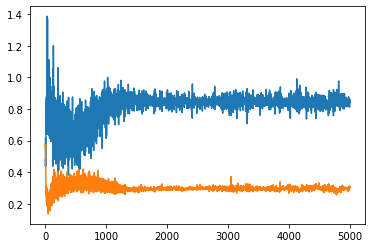

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

### Generar datos

In [ ]:
# Generamos imagen sintética
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
syntetic_images = model_gen.predict(gen_noise)

(-0.5, 27.5, 27.5, -0.5)

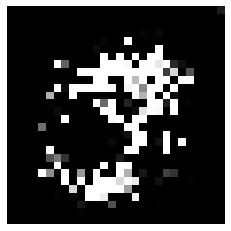

In [ ]:
# Mostramos imagen sintética
plt.imshow(syntetic_images[5,:,:,0],cmap='gray')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

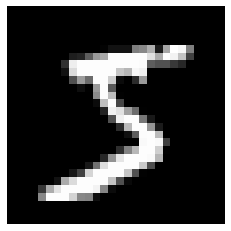

In [ ]:
# Esto es una imagen real (por comparar)
plt.imshow(X_train[0,:,:,0],cmap='gray')
plt.axis('off')

# Ejercicios

1) Modifica el código para incluir la generación de las etiquetas 

2) Modifica el código para que use el dataset cifar10 en lugar del mnist 

3) Modifica el código para que use capas convolucionales en lugar de densas (en la medida de lo posible).

# Ejercicios EXTRA

4) Modifica el código para balancear cuanto aprende el generador y cuanto el discriminador.

Por ejemplo haz que el número de datos en el batch de entrenamiento dependa del coste (loss) en el paso de entrenamiento anterior de cada modelo (generador o discriminador). Es decir, si el discriminador aprende mucho (su loss es bajo) en el siguiente paso de entrenamiento le daré menos datos (opara que aprenda menos).  

5) Crea un modelo que incluya todas las modificaciones de los cuatro ejercicios anteriores.